In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal, uniform, bernoulli
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rc('legend', fontsize=11)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

In [ ]:
# Script hyperparameters
p = 5
N = 1000
T_met = 1000
T_gib = 1000
plots = True # if False, runs the algorithms without graphical diagnostic checks
thinning = 2 # To reduce autocorrelation

# SIMULATION
# Seed to generate the same data
np.random.seed(1234)

# create intercept
x_0 = np.ones((N,1))

# create a sample of p normal covariates
X = multivariate_normal(mean=np.zeros(p)).rvs(size=N)
X = np.hstack((x_0,X))

# simulate the true betas from a norm(0,d)
sd = 2
beta_true = np.random.normal(0,sd,p+1)
beta_true = np.matrix(beta_true).T

# define probit function
probit = norm.cdf

# Apply probit model
eta = np.dot(X,beta_true)
pi = probit(eta)
# Generate dependent variable
Y = bernoulli.rvs(p=pi,size=(N,1))

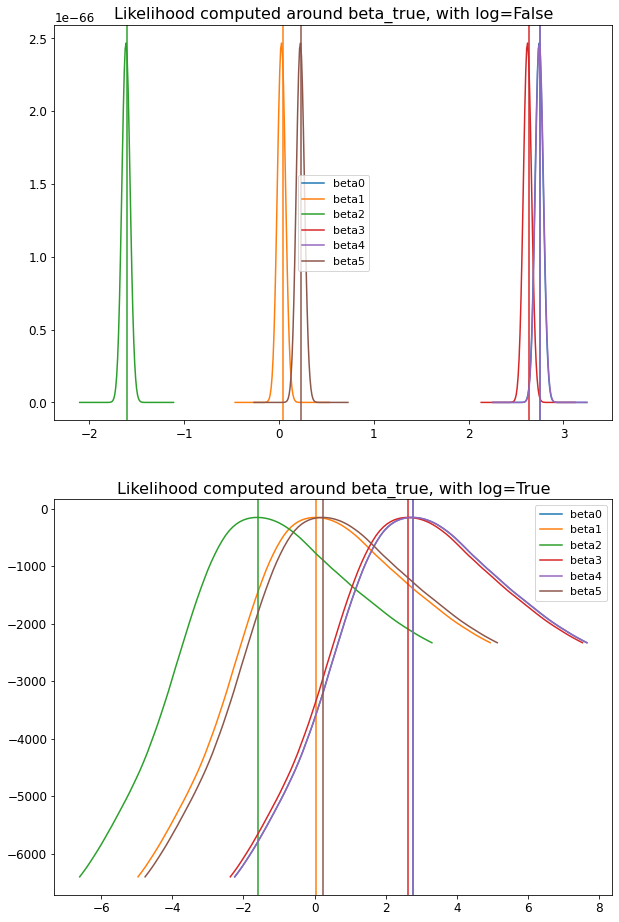

In [ ]:
# define prior for Metropolis
def prior(x): 
    return multivariate_normal(mean=np.zeros(p+1)).pdf(x.flatten())

# define posterior as in slide 2
def posterior(beta, pi, Y, prior, log_=False):
    if log_:
        lik = np.sum(np.log(pi**Y * (1-pi)**(1-Y)))
        return np.log(prior(beta)) + lik
    else:
        lik = np.prod(pi**Y * (1-pi)**(1-Y))
        return prior(beta) * lik

# Check that the likelihood is well defined
def plot_likelihood(posterior, beta_true, Y, colors=colors):
    p = beta_true.shape[0]
    fig, axs = plt.subplots(2,1,figsize=(10,16))
    #plt.suptitle("The posterior is maximized in beta_true", fontsize=14)
    for log, ax in zip([False,True],axs):
        y_t = []
        X_t = []
        if log:
            D = np.arange(-5, +5, .1)
        else:
            D = np.arange(-.5, +.5, .01)
        for d in D:
            x = beta_true + d
            X_t.append(x)
            p_t = probit(np.dot(X,x))
            p_t = np.minimum(p_t,.999999)
            p_t = np.maximum(p_t,.000001)
            y_t.append(posterior(x,p_t,Y,prior,log_=log))
        X_t = np.array(X_t).reshape(len(D),p).T
        for i in range(p):
            ax.plot(X_t[i],y_t)
            ax.set_title(f"Likelihood computed around beta_true, with log={log}", fontsize=16)
            ax.axvline(x=beta_true[i], c=colors[i], label=f'beta{i}')
            ax.legend()
    plt.show()
if plots:
    plot_likelihood(posterior,beta_true,Y)
# We can see that it's far better to use log-likelihood since we would incur in very small values otherwise

In [ ]:
#@title Utility functions
def fisher_mat(X, W):
    fisher = np.linalg.multi_dot([X.T, W, X])
    return fisher

def trace_plot(sample_plot, post_m=None, beta_true=None, from_=0, title="Trace plot", separate_plots=False, colors=colors):
    """Function that plots the trace of the sample generated and tracks its mean.
    """
    if beta_true is not None:
        beta = beta_true.T.tolist()[0]
    T = sample_plot.shape[1]
    p = sample_plot.shape[0]
    if from_ != 0 and from_ < 1:
        from_ = int(from_*T)
    T = T - from_
    if separate_plots:
        r = int(np.ceil(np.sqrt(p)))
        c = int(np.ceil((p)/r))
        fig, axs = plt.subplots(r,c,figsize=(6*r,6*c), sharex=True)
        j = 0
        for i in range(p):
            if post_m is None:
                m = np.mean(sample_plot[i][from_:])
                axs[j,i%c].plot(np.arange(T),np.zeros(T)+m, c='black', lw=1, label=f'Estimated beta{i} = {m:.5f}')
            else:
                m = post_m[i]
                axs[j,i%c].plot(np.arange(T),np.zeros(T)+m, c='black', lw=1, label=f'Estimated beta{i} = {m:.5f}')
            axs[j,i%c].plot(sample_plot[i][from_:], c=colors[i%len(colors)])
            axs[j,i%c].set_title(f"Beta {i}", fontsize=14)
            if beta_true is not None:
                axs[j,i%c].plot(np.arange(T),np.zeros(T)+beta[i], c=colors[i%len(colors)], lw=1, label=f'True beta{i} = {beta[i]:.5f}')
            axs[j,i%c].legend()
            if i%c == c-1:
                j += 1
        if from_ != 0:
            fig.suptitle(title + f" trace plot, burn-in = {from_}", fontsize=24)
        else:
            fig.suptitle(title + " trace plot", fontsize=24)
        plt.show()
    else:
        plt.figure(figsize=(12,8))
        for i in range(p):
            m = np.mean(sample_plot[i][from_:])
            plt.plot(sample_plot[i][from_:], label=f"Beta {i}, mean = {m:.5f}")
        plt.legend()
        plt.title(title, fontsize=24)
        plt.show()

def compute_means(sample_m, sample_g, beta_true, burn_in=0):
    if burn_in == 0:
        from_m, from_g = 0, 0
    elif burn_in < 1:
        from_m = int(burn_in * len(sample_m))
        from_g = int(burn_in * len(sample_g))
    elif burn_in >= 1:
        from_m = burn_in if len(sample_m) > burn_in else 0
        from_g = burn_in if len(sample_g) > burn_in else 0
    m_met = np.mean(sample_m[from_m:], axis=0)[0]
    m_gib = np.mean(sample_g[from_g:], axis=0)
    s = ' ' * 32
    for i in range(len(beta_true)):
        s += f"beta{i}" + " "*7
    a = from_m if from_m == from_g else (from_m, from_g)
    print(f" Comparing the estimated means, with burn-in = {a}\n")
    print(s)
    print("Metropolis estimates\t",m_met)
    print("Gibbs estimates\t\t",m_gib)
    print("\nTrue values of beta\t",beta_true.T)

    return m_met, m_gib

def plot_linear_model(X, Y, m_met, m_gib, colors=colors):
    p = len(m_met)
    r = int(np.ceil(np.sqrt(p)))
    c = int(np.ceil((p)/r))
    fig, axs = plt.subplots(r,c,figsize=(8*c,6*r), sharex=True, sharey=True)
    i = 0
    for row in axs:
        for ax in row:
            X_ = X.T[i]
            ax.scatter(X_,Y, facecolors='none', edgecolor=colors[2], lw=0.5, label="Data")
            if i == 0:
                x_ = 1
                ax.scatter(x_,probit(np.dot(x_,m_met[i])), marker='_', label=f'Met, beta = {m_met[i]:.3f}')
                ax.scatter(x_,probit(np.dot(x_,m_gib[i])), marker='_', label=f'Gib, beta = {m_gib[i]:.3f}')
                ax.scatter(x_,probit(np.dot(x_,beta_true[i,0])), marker='_', label=f'True, beta = {beta_true[i,0]:.3f}', c=colors[3])
            else:
                x_ = np.linspace(np.min(X_),np.max(X_),100)
                ax.plot(x_,probit(np.dot(x_,m_met[i])), label=f'Met, beta = {m_met[i]:.3f}')
                ax.plot(x_,probit(np.dot(x_,m_gib[i])), label=f'Gib, beta = {m_gib[i]:.3f}')
                ax.plot(x_,probit(np.dot(x_,beta_true[i,0])), label=f'True, beta = {beta_true[i,0]:.3f}', c=colors[3])
            ax.set_title(f"Beta {i} coefficient", fontsize=14)
            ax.legend()
            ax.set_ylabel("Y")
            if i == 0:
                ax.set_xlabel("Intercept covariate")
            else:
                ax.set_xlabel(f"Covariate {i}")
            i += 1            
    fig.suptitle("Probit model function", fontsize=26)
    plt.show()

def plot_autocorrelation(sample_m_plot, sample_g_plot, maxlags=100):
    p = sample_m_plot.shape[0]
    Nm = sample_m_plot.shape[1]
    Ng = sample_g_plot.shape[1]
    if maxlags < 1:
        max_m = int(Nm*maxlags)
        max_g = int(Ng*maxlags)
    else:
        max_m, max_g = maxlags, maxlags
    r = int(np.ceil(np.sqrt(p)))
    c = int(np.ceil((p)/r))
    fig, axs = plt.subplots(r,c,figsize=(8*c,6*r))
    i = 0
    for row in axs:
        for ax in row:
            ax.acorr(sample_m_plot[i], usevlines=False, label='Met', marker='o', maxlags=max_m)
            ax.acorr(sample_g_plot[i], usevlines=False, label='Gib', marker='x', maxlags=max_g)
            ax.set_title(f"Beta{i} Autocorrelation", fontsize=14)
            i += 1
            ax.legend()
    plt.show()

def plot_hist(sample_m_plot, sample_g_plot, beta_true, m_met=None, m_gib=None, burn_in=0, error=.05, bins=20, colors=colors):
    p = sample_m_plot.shape[0]
    Nm = sample_m_plot.shape[1]
    Ng = sample_g_plot.shape[1]
    r = int(np.ceil(np.sqrt(p)))
    c = int(np.ceil((p)/r))
    if burn_in == 0:
        from_m, from_g = 0, 0
    elif burn_in < 1:
        from_m = int(burn_in * Nm)
        from_g = int(burn_in * Ng)
    elif burn_in >= 1:
        from_m = burn_in if Nm > burn_in else 0
        from_g = burn_in if Ng > burn_in else 0
    fig, axs = plt.subplots(r,c,figsize=(8*c,6*r))
    i = 0
    for row in axs:
        for ax in row:
            ax.hist(sample_m_plot[i][from_m:],bins=bins,label="Metropolis",histtype='step', color=colors[0])
            ax.hist(sample_g_plot[i][from_g:],bins=bins,label="Gibbs",histtype='step', color=colors[1])
            ax.axvline(x=beta_true[i], ls='--', c='black', label=f'True beta{i}')
            low_err, high_err = beta_true[i]*(1-error), beta_true[i]*(1+error)
            ax.axvline(x=low_err, ls='--', lw=1, c='grey')
            ax.axvline(x=high_err, ls='--', lw=1, c='grey')
            ax.axvspan(low_err,high_err, color='grey', alpha=0.1, label=f'{100*error:.1f}% relative error')
            if m_met is None:
                m_met_ = np.mean(sample_m_plot[i][from_m:])
                ax.axvline(x=m_met_, c=colors[0], label=f'Est. beta{i} (Met)')
            else:
                ax.axvline(x=m_met[i], c=colors[0], label=f'Est. beta{i} (Met)')
            if m_gib is None:
                m_gib_ = np.mean(sample_g_plot[i][from_g:])
                ax.axvline(x=m_gib_, c=colors[1], label=f'Est. beta{i} (Gib)')
            else:
                ax.axvline(x=m_gib[i], c=colors[1], label=f'Est. beta{i} (Gib)')
            ax.set_title(f"Sampled Beta{i} distributions", fontsize=14)
            ax.legend()
            i += 1
    if burn_in == 0:
        fig.suptitle("Estimated beta's distributions", fontsize=24)
    else:
        fig.suptitle(f"Estimated beta's distributions, burn-in = {burn_in}", fontsize=24)
    plt.show()

In [ ]:
#@title Metropolis and Gibbs functions
def metropolis(posterior, prior, X, T, Y, proposal=multivariate_normal, log_=False, plot_acc=False, prop_var=None, tau=1, start=None, thinning=1):
    """
    Algorithm for implementing the Metropolis-Hastings technique to solve a Bayesian linear model.

    Args:
        posterior (function): kernel of the joint density function that we wish to sample from. It must include an argument for log_.
        prior (function): density function on the parameters that is assumed as prior.
        X (np.matrix): Covariates of the linear model in the shape (N,p)
        Y (np.matrix): Dependent variable of the linear model in teh shape (N,1)
        T (int): Number of iterations to run the algorithm. Coincides with the size of the sample generated.
        link (function, optional): If None, then a linear regression is assumed. Otherwise it corresponds to the function applied to the X*beta. Defaults to None.
        proposal (function, optional): Random variable to generate the proposed samples from. Must have p dimensions. Defaults to multivariate_normal.
        log_ (bool, optional): If true, computes the log-posterior, which is computationally stable. Defaults to False.
        plot_acc (bool, optional): If true, plots the acceptance ratio at the end. Defaults to False.
        prop_var (str, optional): If 'fisher' then the fisher information matrix is used to update the variance of the proposal distribution. If None, then a unitary variance is used.  Defaults to None.
        tau (int, optional): Scaling factor for the variance of the proposal distribution. Defaults to 1.
        start (array-like, optional): Starting point for the algorithm chain. If None, then it start from zero. Defaults to None.
        thinning (int, optional): Sampling parameter, must be an integer greater or equal than 1. It downsizes the final sample so to reduce autocorrelation. E.g.: if thinning=3 then only a sample every 3 iterations is returned. Defaults to 1.

    Returns:
        sample (list): list of np.array, of lentght T, contaning the samples from the posterior.
        ratio (np.array): at index i, it contains the acceptance ratio after iteration i.
    """
    
    print(f"Sampling with Metropolis: log={log_}, tau={tau}, thinning={thinning}")

    N, p = X.shape
    if start is None:
        beta_0 = np.zeros((p,1))
    else:
        beta_0 = start.reshape(p,1)
    sample = []
    if prop_var is None:
        tau = 3
        var = tau * np.eye(p)
    accepted = []
    # Starting point
    e_0 = np.dot(X,beta_0)
    p_0 = probit(e_0)
    p_0 = np.minimum(p_0,.999999) # Necessary to avoid Nan or inf
    p_0 = np.maximum(p_0,.000001)
    for i in range(T):
        if prop_var == 'fisher' and (i == 0 or accepted[-1] == 1):
            mu_t = norm.pdf(e_0)**2 / (p_0*(1-p_0))
            W = np.diag(mu_t.flatten())
            var = tau * np.linalg.inv(fisher_mat(X, W))
        beta_t = proposal.rvs(mean=beta_0.flatten(), cov=var).reshape(p,1)
        e_t = np.dot(X,beta_t)
        p_t = probit(e_t)
        p_t = np.minimum(p_t,.999999) # Necessary to avoid Nan or inf
        p_t = np.maximum(p_t,.000001)
        u = uniform(0,1).rvs()
        if log_:
            acc = posterior(beta_t,p_t,Y,prior,log_) - posterior(beta_0,p_0,Y,prior,log_)
            u = np.log(u)
        else:
            acc = min(1,posterior(beta_t,p_t,Y,prior)/posterior(beta_0,p_0,Y,prior))
        if acc >= u:
            if i % thinning == 0:
                sample.append(beta_t.reshape(1,p))
            beta_0 = beta_t
            p_0 = p_t
            e_0 = e_t
            accepted.append(1)
        else:
            if i % thinning == 0:
                sample.append(beta_0.reshape(1,p))
            accepted.append(0)
        if i % (T//10) == 0:
            print(f"\tI'm at {i} / {T}")
    ratio = np.cumsum(accepted) / np.arange(1,T+1)
    if plot_acc:
        plt.figure(figsize=(10,8))
        plt.plot(ratio)
        plt.title(f"Metropolis Acceptance Ratio at each iteration, final = {np.mean(accepted)}", fontsize=18)
        plt.show()
    else:
        print(f" Acceptance ratio = {ratio[-1]:.3f}")

    return sample, ratio

def auxiliary_gibbs(X, Y, T, with_prior=False, start=None, thinning=1, posterior=None, prior=None):
    """Algorithm for implementing an Auxiliary Gibbs sampling technique to solve a Bayesian linear model

    Args:
        X (np.ndarray): Covariates of the linear model in the shape (N,p).
        Y (np.ndarray): Dpendent variable of the linear model in the shape (N,1).  
        T (int): Number of iterations to run the algorithm. Coincides with the size of the sample generated.
        with_prior (bool, optional): If True, uses a multivariate normal (0,1) as prior. If False, uses a diffuse non-informative prior. Defaults to False.
        start (array-like or str, optional): Starting point for the algorithm chain. Options available are {'ols', 'mle'}. If None, then it start from zero. Defaults to None.
        thinning (int, optional): Sampling parameter, must be an integer greater or equal than 1. It downsizes the final sample so to reduce autocorrelation. E.g.: if thinning=3 then only a sample every 3 iterations is returned. Defaults to 1.
        posterior (function, optional): If start='mle', this is the posterior function for the likelihood to maximize. Defaults to None.
        prior (function, optional): If start='mle', this is the prior for the likelihood to maximize. Defaults to None.

    Returns:
        sample (list): list of np.array, of lentght T, contaning the samples from the posterior.
    """
    print(f"Sampling with Auxiliary Gibbs: prior={prior}, thinning={thinning}")

    N, p = X.shape
    sample = []

    if start == 'ols':
        beta_0 = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    elif start == 'mle':
        if posterior is None or prior is None:
            raiseException("To use 'mle', posterior and prior must be specified.")
        else:
            print("Solving MLE...")
            def negLL(x,Y,prior=prior,log=True):
                pi = probit(np.dot(X,x))
                pi = np.minimum(pi,.99999)
                pi = np.maximum(pi,.00001)
                return - posterior(x, pi, Y, prior, log)
            beta_0 = minimize(lambda x: negLL(x,Y), x0=np.zeros((p,1)), options={'disp':False}).x.reshape(p,1)
            print("MLE found")
    elif start is None:
        beta_0 = np.zeros((p,1))
    else:
        beta_0 = np.array(start.tolist()).reshape(p,1)
    
    if not with_prior:
        # Diffuse prior
        v = np.linalg.inv(np.dot(X.T, X))
    else:
        # Conjugate normal prior (m=0, v=1)
        v = np.linalg.inv(np.linalg.inv(np.eye(p)) + np.dot(X.T, X))
        m0 = np.dot(np.linalg.inv(np.eye(p)),np.zeros((p,1)))

    # elements for sampling from truncated normal
    a = np.zeros(N)
    b = np.zeros(N)
    a[(Y.T == 0).flatten()] = -np.inf
    b[(Y.T == 1).flatten()] = np.inf
    d = np.ones(N)

    beta_t = beta_0

    for i in range(T):
        # 1st step - Sample the z from a truncated normal with mean=X*x0 and sd=d restricted to (a,b)
        c = np.dot(X,beta_t).flatten()
        u = uniform(0,1).rvs(N)
        A = probit((a-c)/d)
        P = A + u*(probit((b-c)/d)-A)
        z = c + d * norm.ppf(P)

        # 2nd step - Sample the xt from the conditional multi-normal with mean m and variance v
        # Update the mean
        if not with_prior:
            m = np.dot(v,np.dot(X.T,z.T))
        else:
            m = np.dot(v,(m0 + np.dot(X.T,z.T).reshape(p,1)))
        # Sample the betas from the full conditional
        conditional = multivariate_normal(mean=np.array(m.T).flatten(),cov=v)
        beta_t = conditional.rvs()
        if i % thinning == 0:
            sample.append(beta_t)
        if i % (T//10) == 0:
            print(f"\tI'm at {i} / {T}")

    return sample

Sampling with Metropolis: log=True, tau=1, thinning=2
	I'm at 0 / 1000
	I'm at 100 / 1000
	I'm at 200 / 1000
	I'm at 300 / 1000
	I'm at 400 / 1000
	I'm at 500 / 1000
	I'm at 600 / 1000
	I'm at 700 / 1000
	I'm at 800 / 1000
	I'm at 900 / 1000


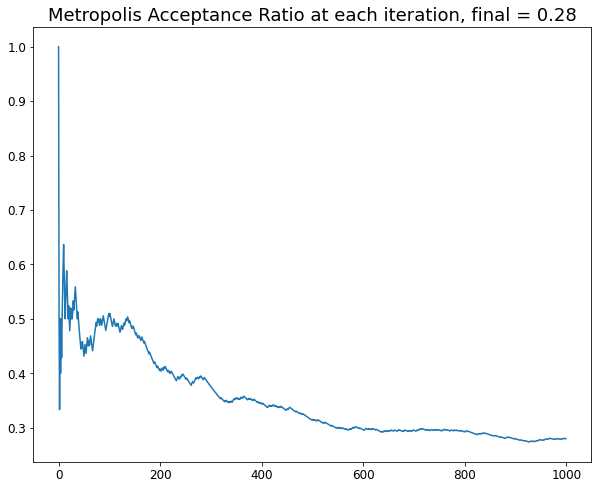

In [ ]:
np.random.seed(None) # to let the algorithms be truly random
sample_m, acc_m = metropolis(posterior, prior, X, T_met, Y, proposal=multivariate_normal, start=None, log_=True, plot_acc=plots, prop_var='fisher', thinning=thinning)

In [ ]:
sample_g = auxiliary_gibbs(X, Y, T_gib, with_prior=True, start=None, thinning=thinning)

Sampling with Auxiliary Gibbs: prior=None, thinning=2
	I'm at 0 / 1000
	I'm at 100 / 1000
	I'm at 200 / 1000
	I'm at 300 / 1000
	I'm at 400 / 1000
	I'm at 500 / 1000
	I'm at 600 / 1000
	I'm at 700 / 1000
	I'm at 800 / 1000
	I'm at 900 / 1000


In [ ]:
m_met, m_gib = compute_means(sample_m, sample_g, beta_true, burn_in=0.1)

 Comparing the estimated means, with burn-in = 50

                                beta0       beta1       beta2       beta3       beta4       beta5       
Metropolis estimates	 [ 2.47493296 -0.11384372 -1.24731282  2.20781167  2.24191452  0.17848285]
Gibbs estimates		 [ 2.60838    -0.10042118 -1.3189699   2.33166306  2.38344415  0.17019539]

True values of beta	 [[ 2.75542292  0.03766845 -1.60162457  2.63199997  2.75763767  0.23711318]]


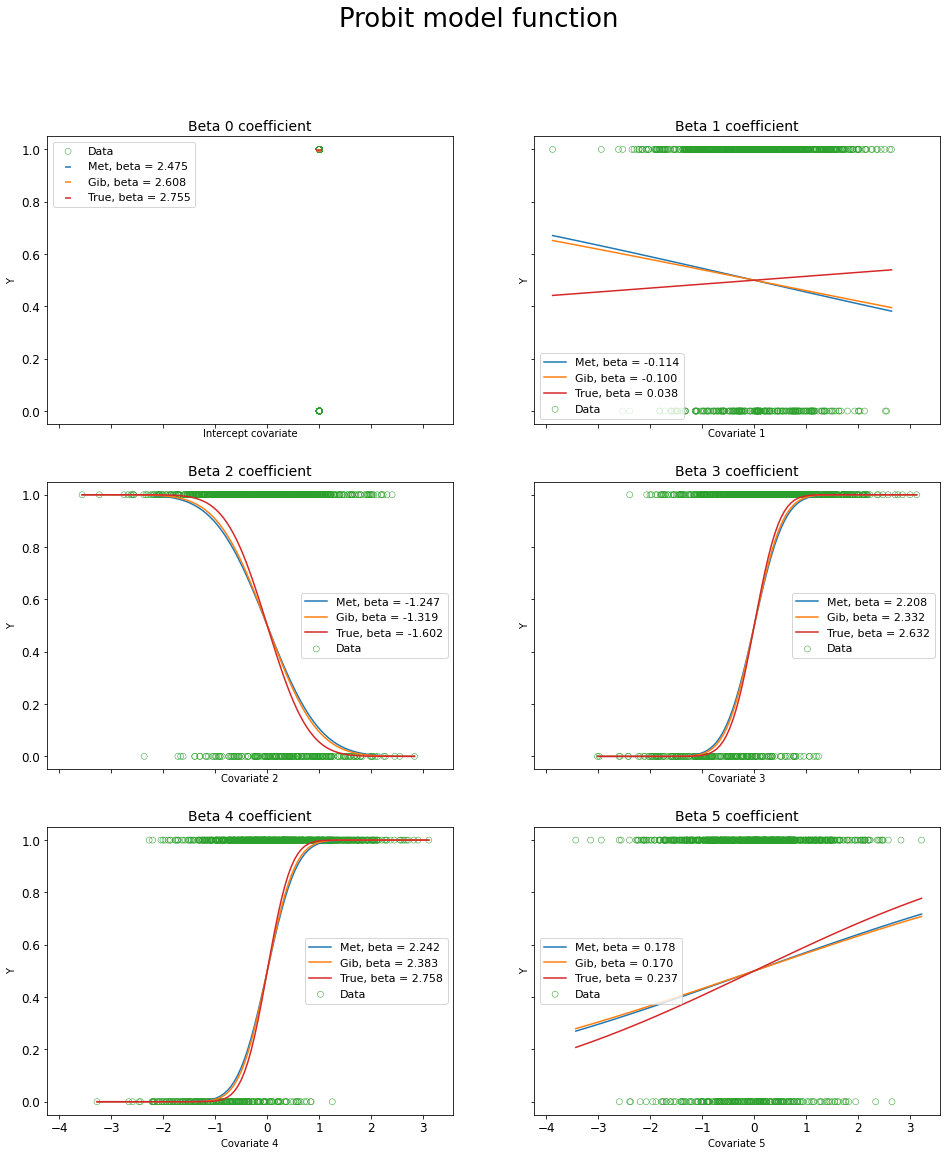

In [ ]:
if plots:
    plot_linear_model(X,Y,m_met,m_gib)

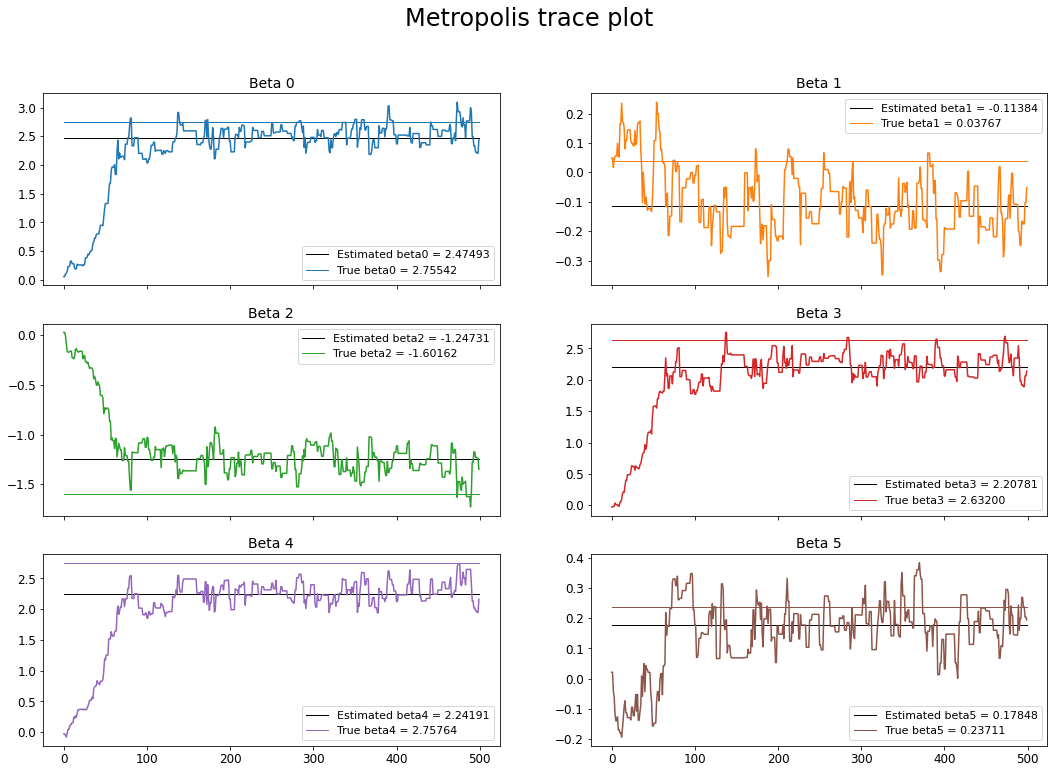

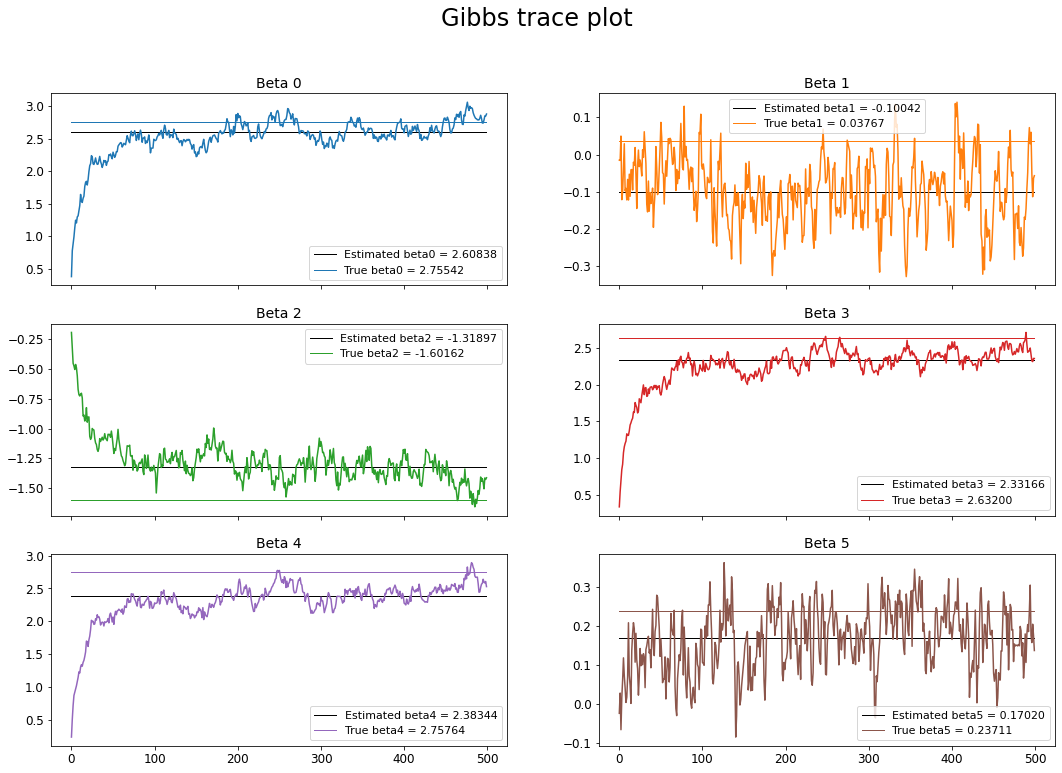

In [ ]:
if plots:
    sample_m_plot = np.array(sample_m).reshape(len(sample_m),p+1).T
    sample_g_plot = np.array(sample_g).T
    trace_plot(sample_m_plot, post_m=m_met, beta_true=beta_true, from_=0, title="Metropolis", separate_plots=True)
    trace_plot(sample_g_plot, post_m=m_gib, beta_true=beta_true, from_=0, title="Gibbs", separate_plots=True)

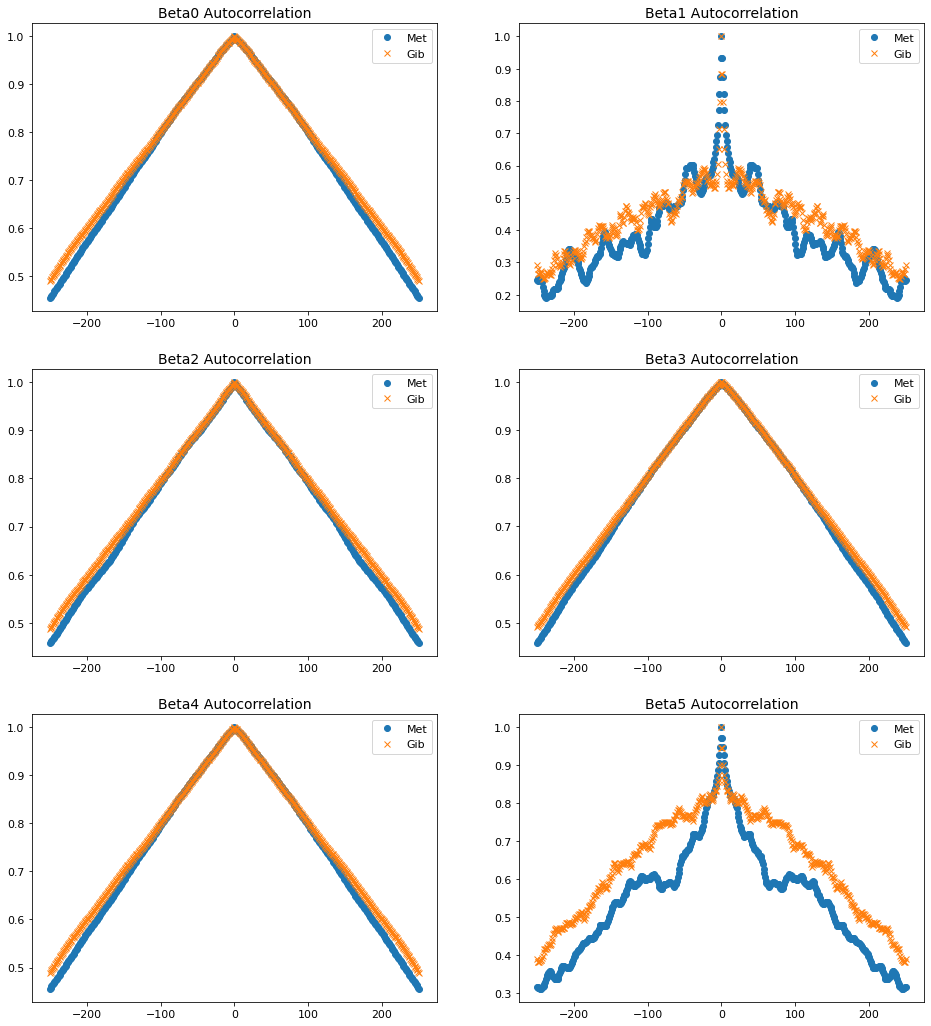

In [ ]:
if plots:
    plot_autocorrelation(sample_m_plot,sample_g_plot, maxlags=0.5)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

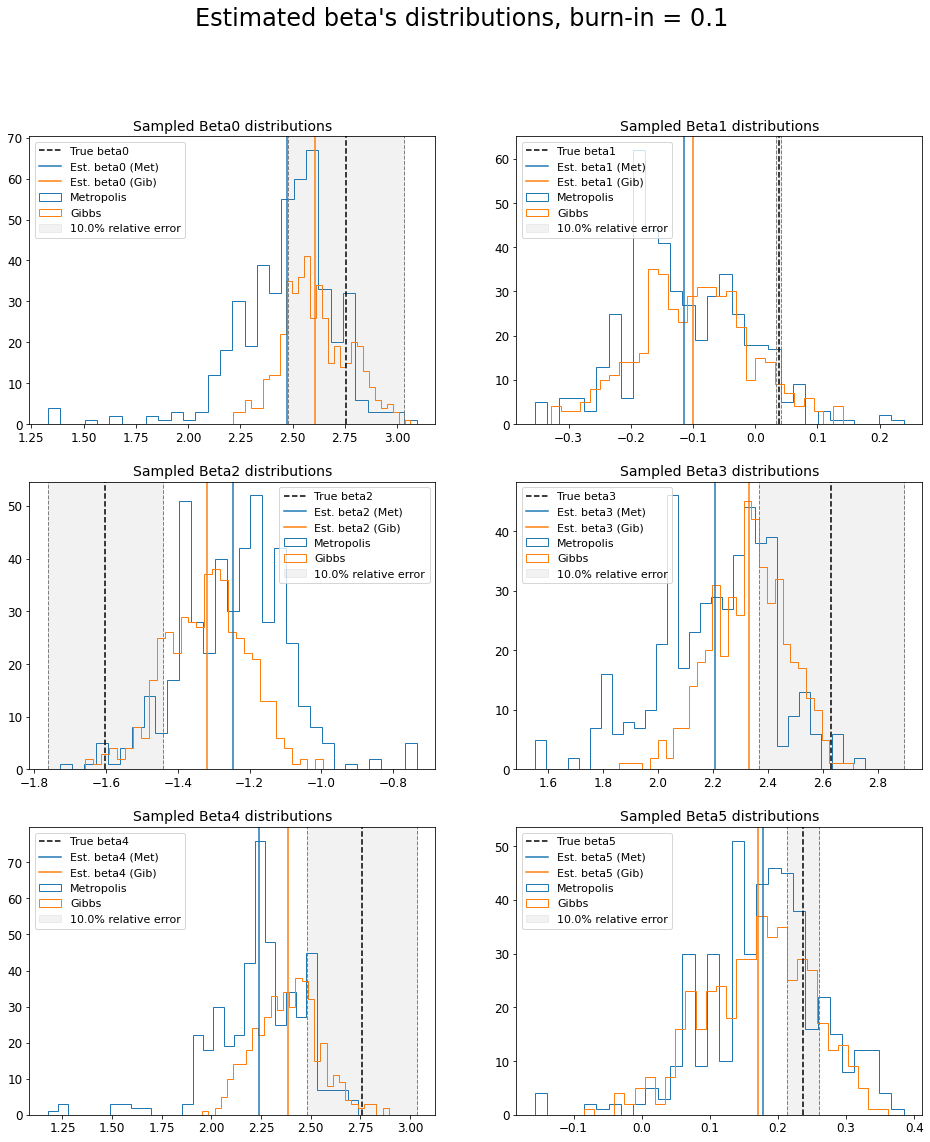

In [ ]:
if plots:
    plot_hist(sample_m_plot, sample_g_plot, beta_true, burn_in=.1, error=.1, bins=30)